In [20]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping


In [22]:
df=pd.read_csv("/content/DESCO.csv",parse_dates=['DATE'])
df.head()

#       DATE TRADING CODE  LTP*  ...   YCP  TRADE  VALUE (mn)    VOLUME
0  439 2018-05-08        DESCO  40.0  ...  40.8    280       7.465  181313.0
1  438 2018-06-08        DESCO  39.9  ...  40.2    131       3.175   79286.0
2  437 2018-07-08        DESCO  40.0  ...  40.0    182      11.427  284763.0
3  436 2018-08-08        DESCO  39.9  ...  40.0    161      11.144  277230.0
4  435 2018-09-08        DESCO  40.2  ...  40.0     99       2.922   73105.0

[5 rows x 12 columns]

In [23]:
# Sort DataFrame by date
df = df.sort_values('DATE')

# Double check the result
df.head()


#       DATE TRADING CODE  LTP*  ...   YCP  TRADE  VALUE (mn)    VOLUME
36  403 2018-01-10        DESCO  43.8  ...  43.8     75       1.989   45311.0
59  380 2018-01-11        DESCO  39.9  ...  41.0    340      14.165  352939.0
37  402 2018-02-10        DESCO  43.4  ...  43.9     28       1.045   23861.0
79  360 2018-02-12        DESCO  40.2  ...  39.9    138       4.990  124690.0
16  423 2018-03-09        DESCO  42.0  ...  41.2    253       4.630  109806.0

[5 rows x 12 columns]

In [24]:
df = df.set_index('DATE')
df.head(3)

# TRADING CODE  LTP*  HIGH  ...   YCP  TRADE  VALUE (mn)    VOLUME
DATE                                      ...                                   
2018-01-10  403        DESCO  43.8  44.5  ...  43.8     75       1.989   45311.0
2018-01-11  380        DESCO  39.9  41.0  ...  41.0    340      14.165  352939.0
2018-02-10  402        DESCO  43.4  44.0  ...  43.9     28       1.045   23861.0

[3 rows x 11 columns]

In [25]:
df['daily_ret'] = df['CLOSEP*'].pct_change()
df['daily_ret'] = df['daily_ret'].fillna(0.0)

In [26]:
df['volatility']= df['daily_ret'].rolling(window=21).std()
df['volatility'] = df['volatility'].fillna(0.0)

In [27]:
df['volatility'] = df['volatility']*100

In [28]:
import matplotlib.pyplot as plt 

In [29]:
df=df.reset_index()['volatility']

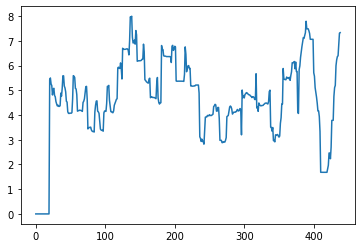

In [30]:
plt.plot(df)

In [31]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df=scaler.fit_transform(np.array(df).reshape(-1,1))

In [32]:
##splitting dataset into train and test split where train=70 percent and test=30 percent
training_size=int(len(df)*0.70)
test_size=len(df)-training_size
train_data,test_data=df[0:training_size,:],df[training_size:len(df),:1]




In [33]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [],[]
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [34]:

# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [35]:

print(X_train.shape), print(y_train.shape)

(206, 100)
(206,)


(None, None)

In [36]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [37]:
X_test.shape

(31, 100, 1)

In [38]:
from google.colab import drive

In [39]:
drive.mount('/content/drive')


ValueError: ignored

In [ ]:
filepath1 = "/content/drive/MyDrive/StockPriceEnsembleDL/modelsDesco/model1.h5"
filepath2 = "/content/drive/MyDrive/StockPriceEnsembleDL/modelsDesco/model2.h5"
filepath3 = "/content/drive/MyDrive/StockPriceEnsembleDL/modelsDesco/model3.h5"

In [ ]:

#1D cnn model
# define model
model1 = Sequential()
model1.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(100,1)))
model1.add(MaxPooling1D(pool_size=2))
model1.add(Flatten())
model1.add(Dense(50, activation='relu'))
model1.add(Dense(1))
model1.compile(optimizer='adam', loss='mse')
model1.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=32,verbose=1)


In [ ]:
model1.save(filepath1)

In [ ]:
#LSTM  model
model2=Sequential()
model2.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model2.add(LSTM(50,return_sequences=True))
model2.add(LSTM(50))
model2.add(Dense(1))
model2.compile(loss='mean_squared_error', optimizer='adam')
model2.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=32,verbose=1)

In [ ]:
model2.save(filepath2)

In [ ]:
#BILSTM model
model3=Sequential()
model3.add(Bidirectional(LSTM(50,return_sequences=True,input_shape=(100,1))))
model3.add(Bidirectional(LSTM(50,return_sequences=True)))
model3.add(Bidirectional(LSTM(50)))
model3.add(Dense(1))
model3.compile(loss='mean_squared_error', optimizer='adam')
model3.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=32,verbose=1)

In [ ]:
model3.save(filepath3)

In [ ]:
from keras.models import load_model

In [ ]:
# create list of loaded models use  load_model() 
all_models = list()
for i in range(3):
  filename = '/content/drive/MyDrive/StockPriceEnsembleDL/modelsDesco/model'+str(i+1)+'.h5'
  model = load_model(filename)
  all_models.append(model)

In [ ]:
print(len(all_models))

In [ ]:
# perform test prediction with per models 
#model1
f1 = '/content/drive/MyDrive/StockPriceEnsembleDL/modelsDesco/model1.h5'
model = load_model(f1)


In [ ]:

test_preds = model.predict(X_test)
print(test_preds.shape)
print(type(test_preds))

In [ ]:
test_preds = np.reshape(test_preds,(1, test_preds.size))
test_predict=scaler.inverse_transform(test_preds)
X = np.reshape(ytest,(1, ytest.size))
Y_test =scaler.inverse_transform(X)

In [ ]:
#Y_test = Y_test.transpose()
RMSE = math.sqrt(mean_squared_error(Y_test,test_preds))
RMSE

In [ ]:

# stacked generalization with linear meta model on blobs dataset
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from keras.models import load_model
from keras.utils import to_categorical
from numpy import dstack

In [ ]:
def DataPrep(datax):
  test_preds = np.reshape(datax,(1, datax.size))
  test_predict=scaler.inverse_transform(test_preds)
  return datax



In [ ]:
def stacked_dataset(allModels, inputX):
	stackX = None
	for model in allModels:
		# make prediction
		yhat = model.predict(inputX, verbose=0)
		# stack predictions into [rows, members, probabilities]
		if stackX is None:
			stackX = yhat
		else:
			stackX = dstack((stackX, yhat))
	# flatten predictions to [rows, members x probabilities]
	
	return stackX

In [ ]:
# fit a model based on the outputs from the ensemble members
def fit_stacked_model(members, inputX, inputy):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, inputX)
	# fit standalone model
	model = LinearRegression()
	model.fit(stackedX, inputy)
	return model

In [ ]:
#make prediction with stacked model

def stacked_prediction(members, model, inputX):
  #inputX = DataPrep(inputX)
	stackedX = stacked_dataset(members,inputX)
	# make a prediction
	yhat = model.predict(stackedX)
	return yhat

In [ ]:
#started from here
for i in range(len(all_models)):
	model = all_models[i]
	for layer in model.layers:
		# make not trainable
		layer.trainable = False
		# rename to avoid 'unique layer name' issue
		layer._name = 'ensemble_' + str(i+1) + '_' + layer.name

In [ ]:

# define stacked model from multiple member input models
def define_stacked_model(members):
	# update all layers in all models to not be trainable
	for i in range(len(members)):
		model = members[i]
		for layer in model.layers:
			# make not trainable
			layer.trainable = False
			# rename to avoid 'unique layer name' issue
			layer._name = 'ensemble_' + str(i+1) + '_' + layer.name
	# define multi-headed input
	ensemble_visible = [model.input for model in members]
	# concatenate merge output from each model
	ensemble_outputs = [model.output for model in members]
	merge = concatenate(ensemble_outputs)
	hidden = Dense(10, activation='relu')(merge)
	output = Dense(3)(hidden)
	model = Model(inputs=ensemble_visible, outputs=output)
	model = Model(inputs=ensemble_visible, outputs=output)
	# plot graph of ensemble
	plot_model(model, show_shapes=True, to_file='model_graph.png')
	# compile
	# compile
	model.compile(optimizer='adam', loss='mse')
	return model

In [ ]:

def fit_stacked_model(model, inputX, inputy):
	# prepare input data
	X = [inputX for _ in range(len(model.input))]
	# encode output data
	#inputy_enc = to_categorical(inputy)
	# fit model
	model.fit(X, inputy, epochs=300, verbose=0)

In [ ]:
stacked_model = define_stacked_model(all_models)

In [ ]:
#fit stacked model on test dataset
fit_stacked_model(stacked_model, X_test,ytest)

In [ ]:

def predict_stacked_model(model, inputX):
	# prepare input data
	X = [inputX for _ in range(len(model.input))]
	# make prediction
	return model.predict(X)

In [ ]:

# make predictions and evaluate
yhat = predict_stacked_model(stacked_model, X_test)
yhat = DataPrep(yhat)
yhat
#Y_test = DataPrep(Y_test)
#RMSE = math.sqrt(mean_squared_error(Y_test,yhat))
#RMSE
#print('Stacked Test Accuracy: %.3f' % RMSE)

In [ ]:
yhat=scaler.inverse_transform(yhat)

In [ ]:
x, y, z = yhat.T

In [ ]:
avg = (x+y+z)/3

In [ ]:
avg = np.reshape(avg,(1, avg.size))
x = np.reshape(x,(1, x.size))
y = np.reshape(y,(1, y.size))
z = np.reshape(z,(1, z.size))

In [ ]:
RMSE = math.sqrt(mean_squared_error(Y_test,avg))
RMSE

In [ ]:
RMSE = math.sqrt(mean_squared_error(Y_test,x))
RMSE

In [ ]:
RMSE = math.sqrt(mean_squared_error(Y_test,y))
RMSE

In [ ]:
RMSE = math.sqrt(mean_squared_error(Y_test,z))
RMSE